# Tarea 1: Reconocimiento basico
Reconocimiento de Patrones (IIC2233)

Primer semestre 2024

Pedro Pablo Zavala Tejos

# 0. Initial Setup

In [1784]:
import numpy as np
import matplotlib.pyplot as plt # Libreria para realizar gráficos
import cv2 # Libreria para procesamiento morfológico de imagenes

# 1. Image Loading


Cargamos los datos


In [1785]:
# !wget https://www.dropbox.com/scl/fi/5n62okx5uosbdtvwyzova/kchipun.zip?rlkey=obnuogv12isstmblsrdmekjkb&dl=0 # Cargamos los datos

In [1786]:
# !mv kchipun.zip?rlkey=obnuogv12isstmblsrdmekjkb kchipun.zip

In [1787]:
# !unzip -qq kchipun.zip # descomprimimos el archivo

In [1788]:
# Funciones para cargar la imagen
def num2fixstr(x: int, d: int) -> str:
    string = '%0*d' % (d, x)
    return string

def get_image_path(num_class: int, num_img: int, sep='_') -> str:
    BASE_URL = 'kchipun/img_'
    DIGITS_CLASS = 2
    DIGITS_IMG = 4
    path = f'{BASE_URL}{num2fixstr(num_class, DIGITS_CLASS)}{sep}{num2fixstr(num_img, DIGITS_IMG)}.png'
    return path

def imageload(num_class: int, num_img: int, echo='off') -> str:
    path = get_image_path(num_class, num_img)
    if echo == 'on':
      print(f'loading image {path} ...')
    img = cv2.imread(path, 0)
    return img

def plot_image(num_class: int, num_img: int, echo='off') -> str:
    img = imageload(num_class, num_img, echo='on')
    plt.imshow(img, cmap='gray')

loading image kchipun/img_01_0001.png ...


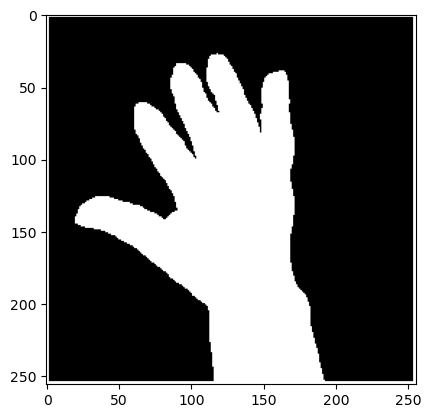

In [1789]:
# Veamos el siguiente ejemplo para cargar la primera imagen de cada clase
# 01: Papel; 02: Piedra; 03: Tijera

# Imagen binaria clase papel
plot_image(1, 1)

loading image kchipun/img_02_0001.png ...


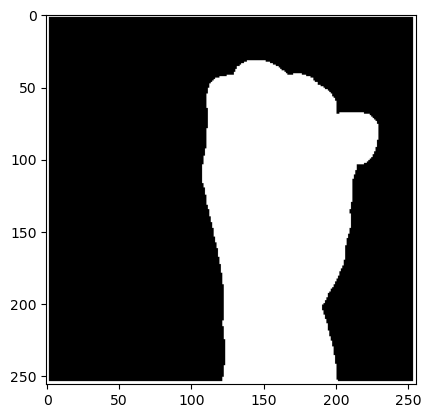

In [1790]:
# Imagen binaria clase piedra
plot_image(2, 1)

loading image kchipun/img_03_0001.png ...


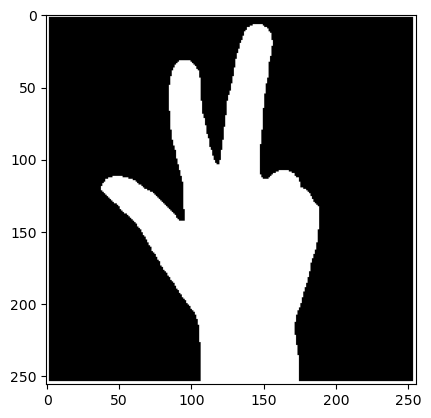

In [1791]:
# Imagen binaria clase tijera
plot_image(3, 1)

# 2. Feature Extraction

In [1792]:
# Morphological Operations

def erode(img):
    return cv2.erode(img, np.ones((5,5), np.uint8), iterations=3)

def close(img):
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))

def dilate(img):
    return cv2.dilate(img, kernel=np.ones((3,3), np.uint8), iterations = 3)

def border(img):
    kernel = np.ones((2,2), np.uint8)
    img = dilate(img)
    border_img = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)
    return border_img

def delete_frame(img):
    return dilate(erode(img))

def rotate_and_flip(img):
    rotate_img = np.rot90(dilate(erode(img)), k=1)
    flip_img = np.flip(rotate_img, axis=0)
    return flip_img


In [1793]:
def get_region(img):
    return img == 255

def get_height_and_width(img):
    region = get_region(img)
    region_coords = np.argwhere(region)
    region_coords_i = region_coords[:,0]
    region_coords_j = region_coords[:,1]

    width = region_coords_i.max() - region_coords_i.min() + 1
    height = region_coords_j.max() - region_coords_j.min() + 1

    return height, width


def center_of_mass(img):
    region = get_region(img) # region de la imagen
    region_coords = np.argwhere(region) # coordenadas que pertenecen a la region con valor distinto de 0

    region_coords_i = region_coords[:,0] # coordenadas i
    region_coords_j = region_coords[:,1] # coordenadas j

    coords_i_sum = np.sum(region_coords_i)
    coords_j_sum = np.sum(region_coords_j)

    area = np.sum(region)

    coord_cm_i = coords_i_sum / area
    coord_cm_j = coords_j_sum / area

    return (coord_cm_i, coord_cm_j)

def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

In [1794]:
def extreme_points(img):
    region_coords = np.argwhere(get_region(img))

    region_axis_i = region_coords[:,0]
    region_axis_j = region_coords[:,1]

    top = tuple(region_coords[region_axis_i.argmin()])
    bottom = tuple(region_coords[region_axis_i.argmax()])
    left = tuple(region_coords[region_axis_j.argmin()])
    right = tuple(region_coords[region_axis_j.argmax()])

    return top, bottom, left, right

def near_points(img):
    most_near_points = []
    region_border = border(img)

    region_coords = np.argwhere(region_border)
    center = center_of_mass(img)

    for point in region_coords:
        # tuple: (point, distance between point and center)
        distance = euclidean_distance(point, center)
        most_near_points.append((tuple(point), distance))

    return sorted(most_near_points, key=lambda x: x[1])

def distance_between_points(*points):
    distances = np.array([])

    for i in range(len(points)):
        if i == len(points) - 1:
            distance_between = euclidean_distance(points[i], points[0])
        else:
            distance_between = euclidean_distance(points[i], points[i+1])
        distances = np.append(distances, distance_between)

    return distances

def mean_distance_to_cm(*points, center):
    distances = np.array([])

    for point in points:
        distance = euclidean_distance(point, center)
        distances = np.append(distances, distance)

    return np.mean(distances)

def roundness(img):
    region = get_region(img)
    region_border = border(img)

    perimeter = get_region(region_border).sum()
    area = np.sum(region)

    roundness = (4 * np.pi * area) / perimeter**2

    return roundness

def normalized_area(img):
    region = get_region(img)
    area = np.sum(region)

    height, width = get_height_and_width(img)
    
    return area / (width * height)

def get_symmetry(img):
    center = center_of_mass(img)
    region = get_region(img)
    region_coords = np.argwhere(region)

    half_region_left = np.array([x for x in region_coords if x[1] <= center[1]])
    half_region_right = np.array([x for x in region_coords if x[1] > center[1]])

    half_region_up = np.array([x for x in region_coords if x[0] <= center[1]])
    half_region_down = np.array([x for x in region_coords if x[0] > center[0]])

    vertical_intersection = np.isin(
        half_region_left, np.flip(half_region_right, axis=0)
    )

    horizontal_intersection = np.isin(
        half_region_up, np.flip(half_region_down, axis=1)
    )

    vertical_symmetry = (np.sum(vertical_intersection)) / np.sum(region)

    horizontal_symmetry = (np.sum(horizontal_intersection)) / np.sum(region)

    return vertical_symmetry, horizontal_symmetry

def get_angle_between_fingers(left, center, top):
    # l: left, c: center, t: top
    lc_vector = np.array(left) - np.array(center)
    ct_vector = np.array(top) - np.array(center)

    norm_lc_vector = euclidean_distance(left, center)
    norm_ct_vector = euclidean_distance(top, center)

    dot_product = np.dot(lc_vector, ct_vector)
    norm_product = norm_lc_vector * norm_ct_vector
    cos = dot_product / norm_product

    angle_rad = np.arccos(cos)
    angle = np.degrees(angle_rad)

    return angle

def center_mass_proportion(img, center):
    extreme_points_array = np.array([extreme_points(img)])

    d_extreme_points_to_cm = np.array([
        euclidean_distance(point, center) for point in extreme_points_array
    ])


    d_near_points_to_cm = np.array([
        distance for point, distance in near_points(img)[:1000:10]
    ])


    proportion = np.mean(d_near_points_to_cm) / np.mean(d_extreme_points_to_cm)


    return np.sum(proportion)

def get_finger_ratio(img):
    top, bottom, left, right = extreme_points(img)
    middle = (left[0], top[1])

    finger_points = [
        point
        for point, _ in near_points(img)[:1000:1] if point[0] < left[0]
    ]

    finger_points_distance = [
        euclidean_distance(point, (middle[0], point[1]))
        for point in finger_points
    ]

    max_distance = max(finger_points_distance)
    
    finger_ratio = np.mean(finger_points_distance) / max_distance

    return finger_ratio

def get_finger_variance(img):
    top, bottom, left, right = extreme_points(img)
    middle = (left[0], top[1])

    finger_points = [
        point
        for point, _ in near_points(img)[:1000:1] if point[0] < left[0]
    ]

    finger_points_distance = [
        euclidean_distance(point, (middle[0], point[1]))
        for point in finger_points
    ]
    fingers_variance = np.var(finger_points_distance)
    return fingers_variance

def get_angle_ratio(img):
    top, bottom, left, right = extreme_points(img)
    middle = (left[0], top[1])
    # rmt: right - middle - top
    # tml: top - middle - left
    angle_rmt = get_angle_between_fingers(right, middle, top)
    angle_tml = get_angle_between_fingers(top, middle, left)
    angle_ratio =  angle_rmt / angle_tml
    
    return angle_ratio

In [1795]:
def get_feature_data(img):
    img = delete_frame(img)

    vertical_symmetry, horizontal_symmetry = get_symmetry(img)

    finger_ratio = get_finger_ratio(img)

    finger_variance = get_finger_variance(img)

    angle_ratio = get_angle_ratio(img)

    roundness_value = roundness(img)

    center_mass_ratio = center_mass_proportion(img, center_of_mass(img))

    center_x = center_of_mass(img)[0]

    center_y = center_of_mass(img)[1]
    
    measure_value = angle_ratio

    print(f'    measure: {measure_value}')
    
    return measure_value

    measure: 0.4710826421944466


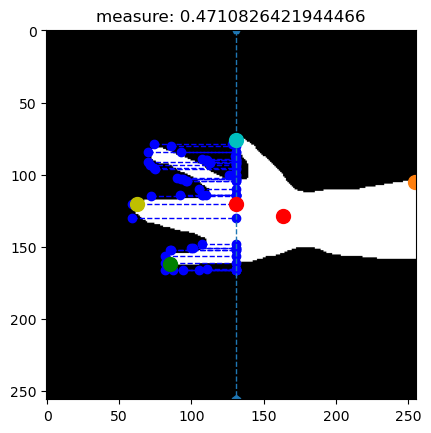

    measure: 0.829760999168169


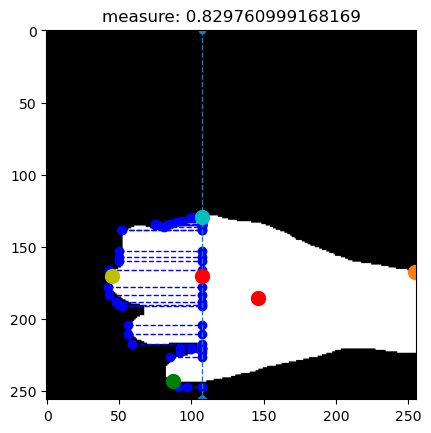

    measure: 0.4576213907301072


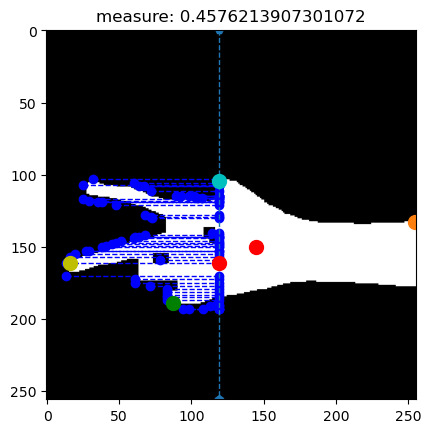

In [1796]:
for i in range(1, 4):
    test_image = imageload(i, 13)
    processed_image = delete_frame(test_image)
    top, bottom, left, right = extreme_points(processed_image)
    center = center_of_mass(processed_image)

    expression = get_feature_data(test_image)
    middle = (left[0], center[1])

    filtered_points = [
        point for point, distance in near_points(processed_image)[:1000:10]
        if point[0] < middle[0]
    ]

    for point in filtered_points:
        plt.plot([point[0], middle[0]], [point[1], point[1]], 'bo--', linewidth=1)


    plt.plot([middle[0], middle[0]], [0, 255], 'p--', linewidth=1)

    plt.plot(*(left[0], top[1]), 'ro', markersize=10)
    plt.plot(*center, 'ro', markersize=10)
    plt.plot(*top, 'yo', markersize=10)
    plt.plot(*left, 'co', markersize=10)
    plt.plot(*bottom, 'o', markersize=10)
    plt.plot(*right, 'go', markersize=10)
    plt.title(f'measure: {expression}')



    plt.imshow(rotate_and_flip(test_image), cmap='gray')
    plt.show()


In [1797]:
K = 3 # Cantidad de clases
N = 50 # Numero de muestras por clases

X = np.zeros((N * K, )) # Creamos un arreglo de tamaño N * K con las caracteristicas
Y = np.zeros((N * K, )) # Creamos nuestra variable de respuesta (con las clases)
index = 0

for k in range(0, K):
    for i in range(1, N + 1):
        img = imageload(k + 1, i, echo='on')
        X[index] = get_feature_data(img)
        Y[index] = k + 1

        index += 1



loading image kchipun/img_01_0001.png ...


    measure: 1.6424152025866132
loading image kchipun/img_01_0002.png ...
    measure: 1.7144777808074174
loading image kchipun/img_01_0003.png ...
    measure: 1.7199875150502775
loading image kchipun/img_01_0004.png ...
    measure: 1.6463617047036325
loading image kchipun/img_01_0005.png ...
    measure: 1.7294516073279027
loading image kchipun/img_01_0006.png ...
    measure: 1.7845578880356199
loading image kchipun/img_01_0007.png ...
    measure: 1.7308028298005096
loading image kchipun/img_01_0008.png ...
    measure: 1.7199875150502775
loading image kchipun/img_01_0009.png ...
    measure: 1.6621841725054907
loading image kchipun/img_01_0010.png ...
    measure: 1.6536033278251268
loading image kchipun/img_01_0011.png ...
    measure: 1.634853605058803
loading image kchipun/img_01_0012.png ...
    measure: 1.7845578880356199
loading image kchipun/img_01_0013.png ...
    measure: 0.4710826421944466
loading image kchipun/img_01_0014.png ...
    measure: 1.7124794812884636
loading

In [1798]:
# Normalization
def minmax(x, x_min, x_max):
    return (x - x_min) / (x_max - x_min)

X_min = np.min(X)
X_max = np.max(X)
X = minmax(X, X_min, X_max)

# 3. Training and testing subsets

In [1799]:
# Datos de entrenamiento de las primeras 40 imagenes de cada clase
x0_train = X[0:40] # Paper
x1_train = X[50:90] # Rock
x2_train = X[100:140] # Scissors

# Datos de testeo de las ultimas 10 imagenes de cada clase
x0_test = X[40:50] # Paper
x1_test = X[90:100] # Rock
x2_test = X[140:150] # Scissors

# Estadisticas de cada clase
# Maximo de cada clase
x0_max = np.max(x0_train)
x1_max = np.max(x1_train)
x2_max = np.max(x2_train)
# Minimo de cada clase
x0_min = np.min(x0_train)
x1_min = np.min(x1_train)
x2_min = np.min(x2_train)
# Promedio de cada clase
x0_mean = np.mean(x0_train)
x1_mean = np.mean(x1_train)
x2_mean = np.mean(x2_train)

In [1800]:

print('Statistics')

print('Class 1 (paper):')
print('>>>> min  = '+str(x0_min))
print('>>>> mean = '+str(x0_mean))
print('>>>> max  = '+str(x0_max))
print(' ')

print('Class 2 (rock):')
print('>>>> min  = '+str(x1_min))
print('>>>> mean = '+str(x1_mean))
print('>>>> max  = '+str(x1_max))

print('Class 3 (scissors):')
print('>>>> min  = '+str(x2_min))
print('>>>> mean = '+str(x2_mean))
print('>>>> max  = '+str(x2_max))


Statistics
Class 1 (paper):
>>>> min  = 0.010064142114440455
>>>> mean = 0.8558418281358504
>>>> max  = 0.996919388741923
 
Class 2 (rock):
>>>> min  = 0.20115019132840473
>>>> mean = 0.4525645355729644
>>>> max  = 1.0
Class 3 (scissors):
>>>> min  = 0.0
>>>> mean = 0.560452086500255
>>>> max  = 0.8991164128536694


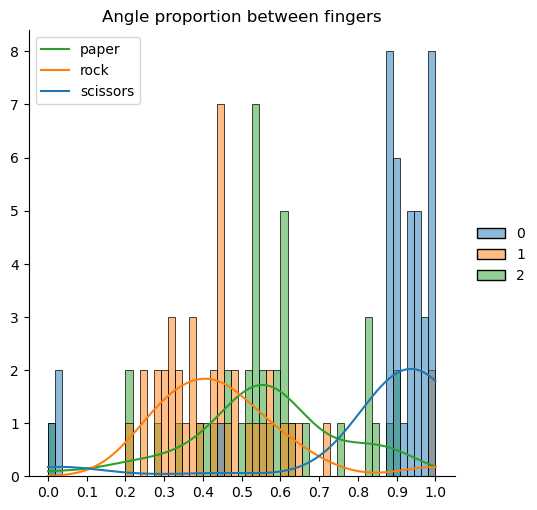

In [1805]:
import seaborn as sns 
# Histograma de análisis de caracteristicas
s = sns.displot([x0_train,x1_train, x2_train],label=['paper', 'rock', 'scissors'], kind='hist', bins=55, kde=True)
plt.legend(labels=['paper', 'rock', 'scissors'])
plt.title('Angle proportion between fingers')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel('')
plt.show()

# 4. Classification

In [1802]:
threshold_1 = (x0_mean + x1_mean) / 2
threshold_2 = (x1_mean + x2_mean) / 2

def classifier(x):
    if x < threshold_1:
        return 1
    elif threshold_1 <= x < threshold_2:
        return 2
    else:
        return 3


Y = np.array([classifier(x) for x in X])

Y1_test = Y[40:50]
Y2_test = Y[90:100]
Y3_test = Y[140:150]

Y1_train = Y[0:40]
Y2_train = Y[50:90]
Y3_train = Y[100:140]

# 5. Evaluation

In [1803]:

def print_accuracy(accuracy, type):
    print(f'\n{type} Accuracy = {accuracy}%')

def get_accuracy(Y, type):
    true_samples = 0
    false_samples = 0

    for k in range(3):
        true_samples += np.sum(Y[k] == k + 1)
        false_samples += np.sum(Y[k] != k + 1)

    accuracy = true_samples / (true_samples + false_samples) * 100

    print_accuracy(accuracy, type)

    return accuracy


def total_accuracy(acc_test, acc_train):
    return 0.20 * acc_train + 0.8 * acc_test

In [1804]:
Y_test = np.array([Y1_test, Y2_test, Y3_test])
Y_train = np.array([Y1_train, Y2_train, Y3_train])

AccTrain = get_accuracy(Y_train, 'Training')
AccTest = get_accuracy(Y_test, 'Testing')
AccTot = total_accuracy(AccTest, AccTrain)
print_accuracy(AccTot, 'Total')



Training Accuracy = 10.833333333333334%

Testing Accuracy = 20.0%

Total Accuracy = 18.166666666666668%
